In [60]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [61]:
import numpy as np

In [62]:
from tidaldisruptionlrd import stellar_distribution, tdr_rate

In [63]:
import importlib

importlib.reload(stellar_distribution)
importlib.reload(tdr_rate)

<module 'tidaldisruptionlrd.tdr_rate' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/tdr_rate.py'>

In [64]:
isothermal_sphere_lc = stellar_distribution.SingularIsothermalSphereProfile(
    r_bin_min=1e-4,
    r_bin_max=1e8,
    N_bins=10000,
    reduce_factor=10,
    N_trapz_bins=1000,
)

Calculating h(eps): 100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s] 


Reconstructing densities: 100%|██████████| 10000/10000 [00:08<00:00, 1131.18it/s]


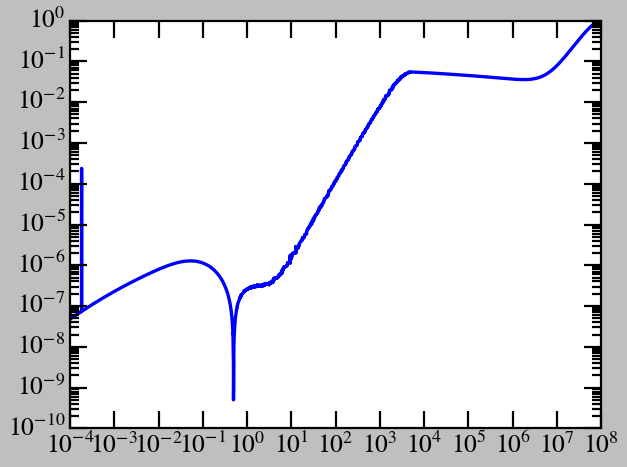

In [65]:
reconstructed_stellar_rho_bins = isothermal_sphere_lc.reconstruct_stellar_rho_bins(
    -isothermal_sphere_lc.phi_bins,
    isothermal_sphere_lc.epsilon_bins,
    isothermal_sphere_lc.g_epsilon_bins,
)

plt.plot(
    isothermal_sphere_lc.r_bins,
    np.abs(1 - reconstructed_stellar_rho_bins / isothermal_sphere_lc.stellar_rho_bins),
)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

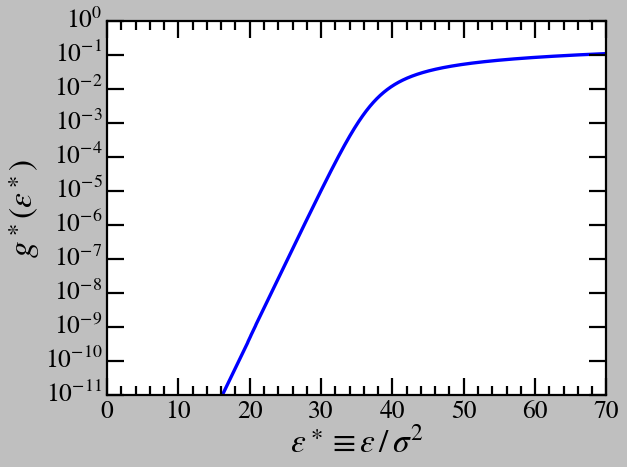

In [66]:
plt.plot(
    isothermal_sphere_lc.epsilon_bins,
    isothermal_sphere_lc.g_epsilon_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(0, 70)
plt.ylim(1e-11, 1e0)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$g^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

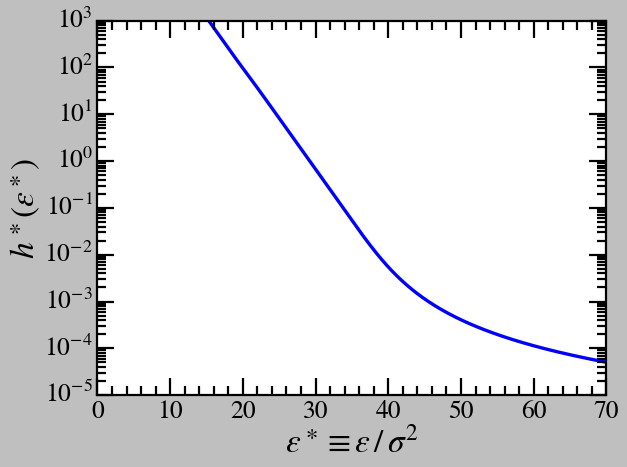

In [67]:
plt.plot(
    isothermal_sphere_lc.reduced_epsilon_bins,
    isothermal_sphere_lc.reduced_h_epsilon_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(0, 70)
plt.ylim(1e-5, 1e3)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$h^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

In [68]:
M_bh = np.logspace(4, 8, 1000)
sigma = 200 * (M_bh / 1.48e8) ** (1 / 4.65)

tdr_Msigma = tdr_rate.TDRRate(
    eta_ast_bins=isothermal_sphere_lc.reduced_epsilon_bins,
    g_ast_bins=isothermal_sphere_lc.reduced_g_epsilon_bins,
    h_ast_bins=isothermal_sphere_lc.reduced_h_epsilon_bins,
    Jc_sqr_ast_bins=isothermal_sphere_lc.reduced_Jc_sqr_bins,
    # P_ast_bins=isothermal_sphere_lc.reduced_P_bins,
    M_bh=M_bh,
    sigma=sigma,
    m_s=1,
    r_s=1,
)

tdr_const_sigma = tdr_rate.TDRRate(
    eta_ast_bins=isothermal_sphere_lc.reduced_epsilon_bins,
    g_ast_bins=isothermal_sphere_lc.reduced_g_epsilon_bins,
    h_ast_bins=isothermal_sphere_lc.reduced_h_epsilon_bins,
    Jc_sqr_ast_bins=isothermal_sphere_lc.reduced_Jc_sqr_bins,
    # P_ast_bins=isothermal_sphere_lc.reduced_P_bins,
    M_bh=M_bh,
    sigma=100,
    m_s=1,
    r_s=1,
)

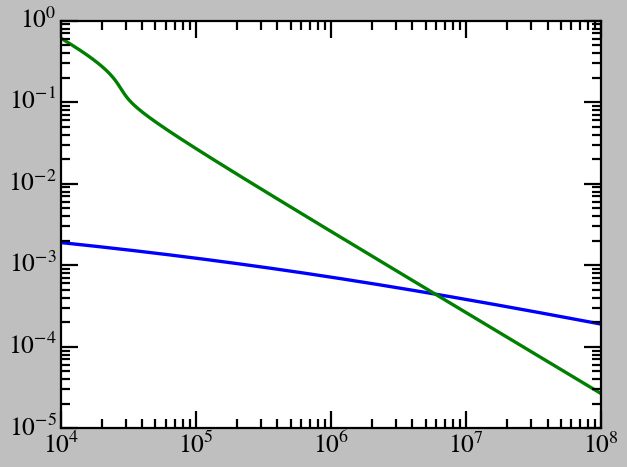

In [69]:
plt.plot(tdr_Msigma.M_bh, tdr_Msigma.N_rate)
plt.plot(tdr_const_sigma.M_bh, tdr_const_sigma.N_rate)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e4, 1e8)
plt.ylim(1e-5, 1e0)

plt.tight_layout()
plt.show()